### Architecture of a classification neural network or model

* **Input layer shape (in_features)**: This should be the same as the number of features in your dataset. 
For example, if you're working with images that are 28x28 pixels, your input layer should have 28*28 = 784 nodes.

* **Hidden Layers**: The number and size of hidden layers are problem-specific. 
Start with one hidden layer with a size in the range of [16, 32, 64, 128, 256, 512, 1024]. 
You can add more layers if needed to extract more complex patterns or features. 
Deep networks can model complex tasks, but they also risk overfitting and require more data and computational power.

* **Output layer shape (out_features)**: This should be the same as the number of classes in your dataset. 
For example, for a binary classification problem, you'd have 2 output nodes. 
For a 10-class problem like MNIST digit classification, you'd have 10 output nodes.

* **Hidden layer activation function**: Common choices are the ReLU (Rectified Linear Unit), Tanh, and Sigmoid functions. 
ReLU is often preferred because it helps mitigate the vanishing gradients problem during backpropagation.

* **Output layer activation function**: For multi-class classification, the softmax function is a common choice as it gives a probability distribution over the classes. 
For binary classification, a single output node with a sigmoid activation function is typically used.

* **Loss function**: Cross entropy loss is used when there are 2 or more classes. 
It measures the dissimilarity between the predicted probability distribution and the actual distribution. 
For multi-class problems, you can use the NLL (Negative Log Likelihood) loss, which is suitable when your outputs are probability distribution estimates.

* **Optimizer**: This is the algorithm used to update the weights of the network. 
Common choices are SGD (Stochastic Gradient Descent), Adam, and RMSProp. 
Adam is often preferred as it combines the advantages of two other extensions of SGD - AdaGrad and RMSProp.

In [2]:
# Import the sklearn library. Sklearn provides simple and efficient tools for data mining and data analysis.
import sklearn

# From sklearn's datasets module, import the make_circles function.
# This function generates a large circle containing a smaller circle in 2D.
from sklearn.datasets import make_circles
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

In [86]:
def print_shape_device(*args):
    """
    This function prints the shape and device of the given tensors or numpy arrays.

    Parameters:
    *args (torch tensor or numpy array): Variable length argument list of tensors or arrays.

    Returns:
    None
    """
    for arg in args:
        if torch.is_tensor(arg):
            print(f"Shape: {arg.shape} | Device: {arg.device}")
        elif isinstance(arg, np.ndarray):
            print(f"Shape: {arg.shape} | Device: CPU")
        else:
            print("Input type not supported. Please provide a torch tensor or a numpy array.")

In [87]:
def normalize_predictions(preds):
    """
    This function normalizes the predictions to either 0 or 1.

    Parameters:
    preds (torch tensor): The model predictions.

    Returns:
    preds (torch tensor): The normalized predictions.
    """
    # Convert the predictions to a numpy array if they are a tensor
    if torch.is_tensor(preds):
        _is_tensor = True
        # Check if the predictions are on the GPU
        preds = preds.cpu().numpy()

    # Normalize the predictions to either 0 or 1
    preds = np.where(preds >= 0.4, 1, 0)

    # Convert the predictions back to a tensor if they were a tensor
    if _is_tensor:
        preds = torch.from_numpy(preds).type(torch.float32)
        preds = preds.to('cuda')

    # Return the normalized predictions
    return preds

In [160]:
# Set the number of samples to be created
n_samples = 1000

# Use the make_circles function from sklearn to create a dataset of 1000 samples.
# The dataset consists of two features (X) and a target variable (y).
# The features are generated as concentric circles, which can be useful for testing classification algorithms.
# The 'noise' parameter adds some random fluctuation to the data to make it a bit more challenging for the model.
# The 'random_state' parameter ensures that the same dataset is generated every time the code is run.
X, y = make_circles(n_samples, noise=0.04, random_state=1)

In [161]:
len(X), len(y)

(1000, 1000)

In [162]:
print(f"First 5 samples:\n{X[:5]}")
print(f"First 5 targets:\n{y[:5]}")

First 5 samples:
[[ 0.84929512  0.02408165]
 [-0.53237389 -0.66381936]
 [ 0.86398088 -0.62633146]
 [-0.09357903 -0.95481426]
 [-1.00384758  0.15916813]]
First 5 targets:
[1 1 0 0 0]


In [163]:
# Explaination of the dataset
# Make dataframe of circle dataset

import pandas as pd
circles = pd.DataFrame({'X0':X[:,0], 'X1':X[:,1], 'label':y})

circles.head()


,X0,X1,label
0,0.849295,0.024082,1
1,-0.532374,-0.663819,1
2,0.863981,-0.626331,0
3,-0.093579,-0.954814,0
4,-1.003848,0.159168,0


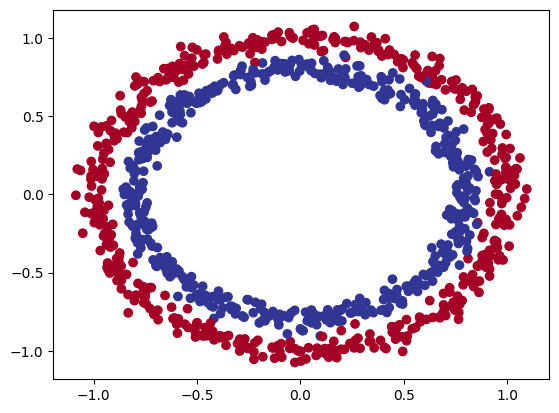

In [164]:
# Plot the dataset
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

**Note :** that the data we are working with is not linearly separable.
and also it is commonly refered to as toy datasets.


In [165]:
# Changing the nmpy arrays into tensors using torch

X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [166]:
# or we can do it manually

train_split = int(0.8*n_samples)
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

#But do remember that this method is not recommended as it is not random and can lead to biased results.

In [167]:
# Splitting datasets into training and testing datasets
# Import the train_test_split function from sklearn's model_selection module.

from sklearn.model_selection import train_test_split

# Use the train_test_split function to split the dataset into training and testing datasets.
# The test_size parameter specifies the ratio of the test dataset, which is set to 20%.
# The random_state parameter ensures that the same split is generated every time the code is run.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [168]:
def plot_scatter(X_train, y_train, X_test = None, y_test = None, title = "Plot"):
    """
    This function plots the training and test data in a scatter plot.
    If it is desired to plot the training and test data in the same plot, the test data can be passed along.
    If it is desired to plot the training and test data set in different plots, the test data can be omitted.
    and the function can be called again with the test data as the training data.

    Parameters:
    X_train (numpy array): The training data features.
    y_train (numpy array): The training data labels.
    X_test (numpy array): The test data features. (optional)
    y_test (numpy array): The test data labels. (optional)
    title (str): The title of the plot.

    Returns:
    None
    """
    # Create a new figure with a specific size
    plt.figure(figsize=(10, 6))

    # Create a scatter plot of the training data.
    # The colors of the points are determined by their labels (y_train).
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu)

    # Create a scatter plot of the test data.
    # The colors of the points are determined by their labels (y_test).
    # This is only done if X_test and y_test are not None.
    if X_test is not None and y_test is not None:
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm , edgecolors='y', alpha=0.6)

    # Set the title of the plot
    plt.title(title)

    # Set the labels of the x and y axes
    plt.xlabel('X0')
    plt.ylabel('X1')

    # Display legend
    plt.legend(['class 0', 'class 1'])

    # Display a color bar
    plt.colorbar()

    # Display the plot
    plt.show()

Data type of X_train: <class 'torch.Tensor'>


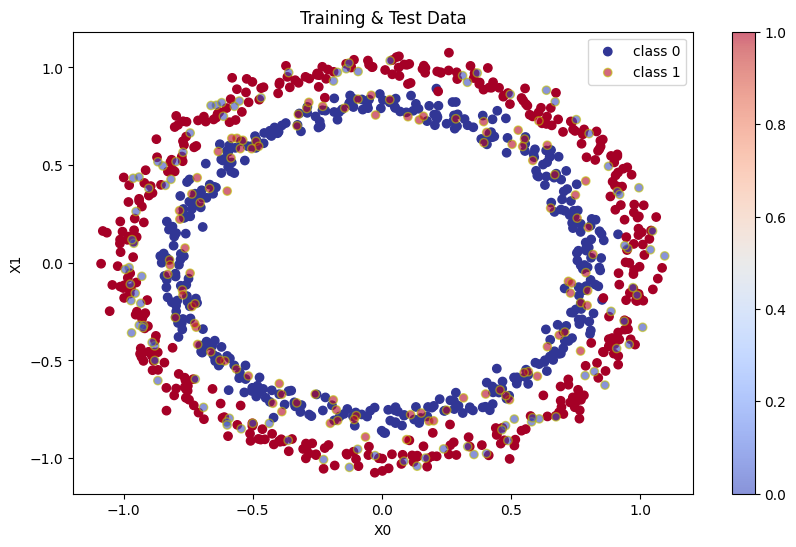

In [169]:
print(f"Data type of X_train: {type(X_train)}")
plot_scatter(X_train, y_train, X_test, y_test, 'Training & Test Data')

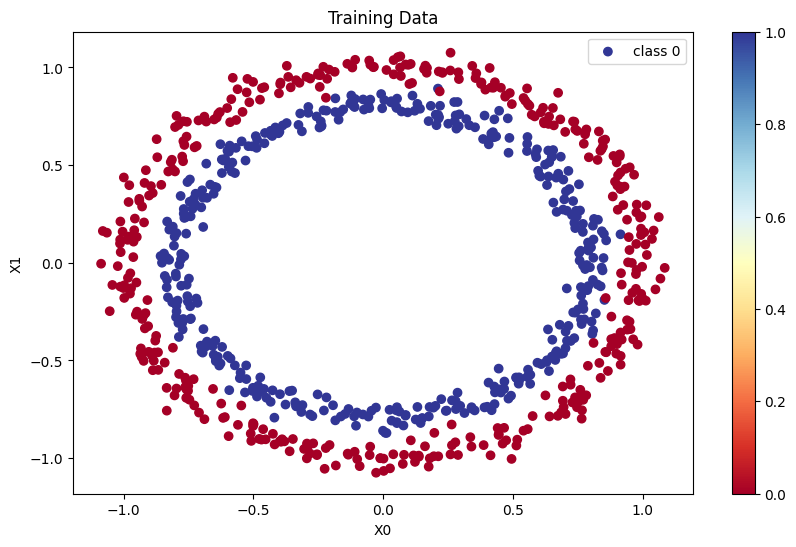

In [170]:

plot_scatter(X_train, y_train, title='Training Data')


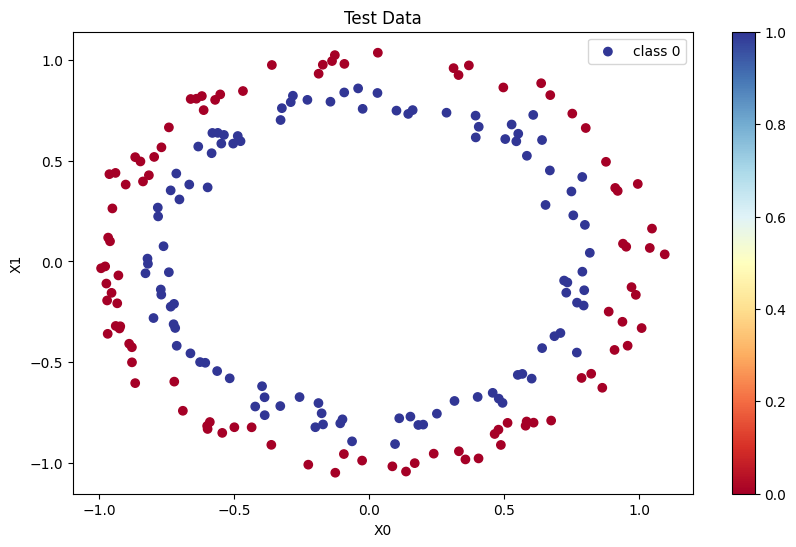

In [171]:
plot_scatter(X_test, y_test, title='Test Data')

### Building a model

To build a neural network with PyTorch, you use the `torch.nn` module.
The network itself is a class inheriting from `torch.nn.Module`.

Now, lets build a model to classify the blue and red dots.

For this we will :
1. Setup a device agnostic code
2. Create a model class (by inheriting from `torch.nn.Module`)
3. Define the layers of the model in the `__init__` method
4. Implement the `forward` method to compute the forward pass through the network
5. Define loss and optimizer functions
6. Create a training and testing loop
    


In [172]:
import torch.nn as nn

# Make device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [173]:
def change_device(device='cpu', *args):
    """
    This function changes the device of the data to the device specified.

    Parameters:
    device (str): The device to which the data should be moved.
    *args (torch tensor or nn.Module): Variable length argument list of tensors or models to be moved.

    Returns:
    result (tuple): A tuple containing the tensors or models moved to the specified device.
    """
    result = []
    for arg in args:
        moved_arg = arg.to(device)
        print(f"Moved {type(arg).__name__} to {device}")
        result.append(moved_arg)
    return tuple(result)

In [174]:
X_train, y_train, X_test, y_test = change_device(device, X_train, y_train, X_test, y_test)


Moved Tensor to cuda
Moved Tensor to cuda
Moved Tensor to cuda
Moved Tensor to cuda


In [175]:

# Construct a neural network
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(in_features= 2, out_features = 8)
        self.hidden_layer1 = nn.Linear(in_features= 8, out_features = 16)
        self.hidden_layer2 = nn.Linear(in_features= 16, out_features = 8)
        self.output_layer = nn.Linear(in_features= 8, out_features = 1)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden_layer1(x))
        x = torch.relu(self.hidden_layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

    # Define a method to move the model to a device
    # This method moves all parameters and buffers of the model to the specified device
    # def to(self, device):
    #     """
    #     This method moves all parameters and buffers of the model to the specified device.
    #     Input:
    #     device (str): The device to which the model should be moved.

    #     Returns:
    #     self (CircleModelV0): The model moved to the specified device.
    #     """
    #     self.input_layer.to(device)
    #     self.hidden_layer1.to(device)
    #     self.hidden_layer2.to(device)
    #     self.output_layer.to(device)
    #     return self


In [176]:
# Instantiate the model
random.seed(42)
model = CircleModelV0()

# Move the model to the device
model = model.to(device)
model.state_dict()

OrderedDict([('input_layer.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]], device='cuda:0')),
             ('input_layer.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691],
                     device='cuda:0')),
             ('hidden_layer1.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
                      [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
                      [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
                      [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
                 

In [177]:
# Make predictions using the model
# The model can be used to make predictions by calling it on the input data.
with torch.inference_mode():
    untrained_preds = model(X_test)

print(f"First 5 predictions:\n{untrained_preds[:5]}")
print(f"Length of predictions: {len(untrained_preds)}")
print(f"Shape of predictions: {untrained_preds.shape}")


First 5 predictions:
tensor([[0.4259],
        [0.4299],
        [0.4247],
        [0.4280],
        [0.4274]], device='cuda:0')
Length of predictions: 200
Shape of predictions: torch.Size([200, 1])


In [178]:
# print shape of X_test, y_test, untrained_preds
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of untrained_preds: {untrained_preds.shape}")


Shape of X_test: torch.Size([200, 2])
Shape of y_test: torch.Size([200])
Shape of untrained_preds: torch.Size([200, 1])


In [179]:
import pandas as pd

def show_preds(X_test, y_test, preds, device='cpu'):
    """
    This function shows the first 5 predictions and the length and shape of the predictions in a tabular form.
    It also handles the conversion between tensor and numpy array, and between different devices.

    Parameters:
    X_test (torch tensor or numpy array): The test data.
    y_test (torch tensor or numpy array): The test data labels.
    preds (torch tensor or numpy array): The model predictions.
    device (str): The device to which the data should be moved.

    Returns:
    None
    """
    # Store the original types of the inputs
    original_types = (X_test.type(), y_test.type(), preds.type())

    # Move data to CPU and convert to numpy if necessary
    X_test, y_test, preds = map(lambda x: x.cpu().numpy() if isinstance(x, torch.Tensor) else x, [X_test, y_test, preds])

    # Split X_test into two 1D arrays if it's a 2D array
    if X_test.ndim == 2:
        X0, X1 = X_test[:, 0], X_test[:, 1]
        X0 = np.squeeze(X0)
        X1 = np.squeeze(X1)
        y_test = np.squeeze(y_test)
        preds = np.squeeze(preds)
        print_shape_device(X0, X1, y_test, preds)
    else:
        raise ValueError("X_test must be a 2D array")

    # Create a DataFrame from the first 5 predictions and actual values
    df = pd.DataFrame({'Data X0': X0[:5], 'Data X1': X1[:5], 'Actual': y_test[:5], 'Predicted': preds[:5]})

    # Display the DataFrame
    print(df.head())

    print(f"Length of predictions: {len(preds)}")
    print(f"Shape of predictions: {preds.shape}")

    # Plot the predictions
    plot_scatter(X_test, y_test, X_test, preds, title='Test Data & Predictions')

    # Convert data back to original types
    X_test, y_test, preds = map(lambda x, orig_type: torch.from_numpy(x).type(orig_type) if "torch" in orig_type else x, [X_test, y_test, preds], original_types)

    # Move data back to original device
    if device == 'cuda':
        X_test, y_test, preds = map(lambda x: x.to(device), [X_test, y_test, preds])





Shape: (200,) | Device: CPU
Shape: (200,) | Device: CPU
Shape: (200,) | Device: CPU
Shape: (200,) | Device: CPU
    Data X0   Data X1  Actual  Predicted
0 -0.718656 -0.329943     1.0   0.425890
1  0.144829  0.731040     1.0   0.429914
2 -0.486845  0.621506     1.0   0.424688
3  0.512952 -0.800250     0.0   0.428048
4 -0.590342 -0.796158     0.0   0.427441
Length of predictions: 200
Shape of predictions: (200,)


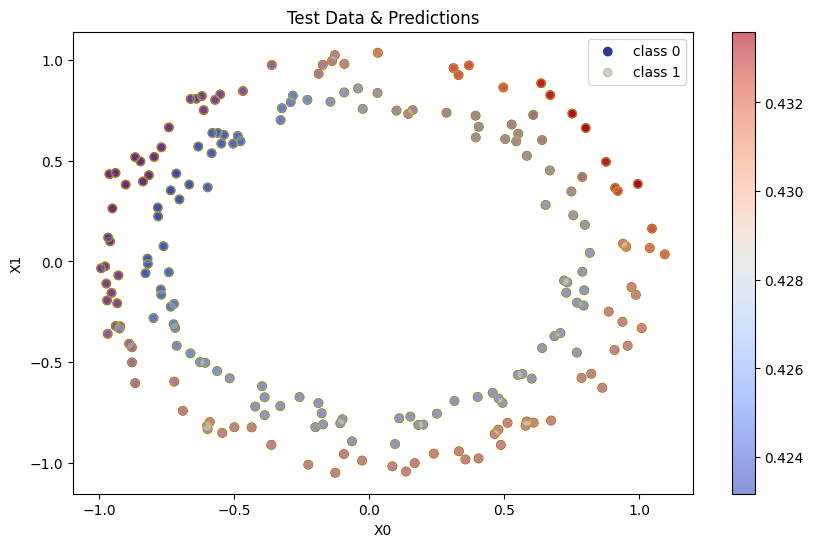

In [180]:
show_preds(X_test, y_test, untrained_preds)
#print device and data type of X_test, y_test, untrained_preds


### Set up loss function and optimizer

Pytorch has many built in options:

GitHub Copilot: In machine learning, choosing the right loss function and optimizer is crucial and often depends on the specific problem:

- The **loss function** measures how well the model's predictions align with the actual values. For binary classification problems like ours, **Binary Cross-Entropy Loss** is often used. This loss function calculates the dissimilarity between the predicted probability distribution and the actual distribution, making it ideal for classification problems where the output is a probability that a given input point belongs to a certain class.

- The **optimizer** is the algorithm used to minimize the loss function. **Adam** is a common choice for binary classification problems. It combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp. Adam adapts the learning rate for each weight in the model individually and calculates adaptive learning rates for different parameters. This means it converges quickly and is less likely to get stuck in local minima.

In conclusion, for our binary classification problem, Binary Cross-Entropy Loss and Adam would be suitable choices for the loss function and optimizer, respectively. However, it's always important to consider the specifics of your problem and possibly experiment with different combinations to find the most effective setup.

For our case we will use:
* **Loss function**: Binary Cross-Entropy Loss `torch.nn.BCEwithLogitsLoss()`
* **Optimizer**: Adam `torch.optim.Adam()`

In [181]:
# Settting up the loss and optimizer

loss_fn = nn.BCEWithLogitsLoss() # has sigmoid activation function built in
optimizer_fn = torch.optim.Adam(model.parameters(), lr=0.01)

In [182]:
# Calculate accuracy
def accuracy_fn(preds, y, device = 'cuda'):
    """
    This function calculates the accuracy of the model's predictions.

    Parameters:
    preds (torch tensor or numpy array): The model predictions.
    y (torch tensor or numpy array): The actual labels.
    device (torch.device): The device to perform calculations on.

    Returns:
    accuracy (float): The accuracy of the model's predictions.
    """
    # Save the original state of the inputs
    preds_orig = preds
    y_orig = y

    # Check the device and data type of the inputs
    if not torch.is_tensor(preds):
        preds = torch.from_numpy(preds).to(device)

    if not torch.is_tensor(y):
        y = torch.from_numpy(y).to(device)

    preds , y = change_device(device, preds, y)
    print_shape_device(preds, y)
    # Normalize the predictions
    preds = normalize_predictions(preds)

    # Calculate the number of correctly classified samples
    correct = torch.eq(preds, y).sum().item()

    # Calculate the total number of samples
    total = y.shape[0]

    # Calculate the accuracy
    accuracy = correct / total

    # Convert the inputs back to their original state
    if isinstance(preds_orig, np.ndarray):
        preds = preds.cpu().numpy()
    if isinstance(y_orig, np.ndarray):
        y = y.cpu().numpy()

    # Return the accuracy
    return accuracy

In [183]:
print(f"Accuracy of untrained model: {accuracy_fn(preds = untrained_preds, y= y_test):.4f}")

Moved Tensor to cuda
Moved Tensor to cuda
Shape: torch.Size([200, 1]) | Device: cuda:0
Shape: torch.Size([200]) | Device: cuda:0
Accuracy of untrained model: 103.0000


In [184]:
def train_model(model : CircleModelV0, loss_fn, optimizer, X_train, y_train, X_test, y_test, epochs=100):
    """
    Train a PyTorch model with the given parameters.

    Args:
        model (nn.Module): The PyTorch model to train.
        loss_fn (nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        X_train (torch.Tensor): The training data.
        y_train (torch.Tensor): The training labels.
        X_test (torch.Tensor): The testing data.
        y_test (torch.Tensor): The testing labels.
        epochs (int, optional): The number of epochs to train for. Defaults to 1000.

    Returns:
        dict: A dictionary containing the trained model and the loss values for each epoch.
        {
            model: .
            loss_values: .
            test_loss_values: .
        }
    """
    # Step 1: Set the seed for generating random numbers
    torch.manual_seed(42)

    # Step 2: Initialize lists to store epoch count, loss values, and test loss values
    epoch_count = []
    loss_values = []
    accuracy_values = []
    test_loss_values = []

    # Step 3: Training loop
    for epoch in range(epochs):
        # Step 4: Set the model to training mode
        model.train()
        epoch_count.append(epoch)

        # Step 5: Forward pass - compute predicted y by passing x to the model
        y_pred = model(X_train)

        # Step 6: Compute loss
        loss = loss_fn(y_pred, y_train)
        loss_values.append(loss.item())

        # Step 7: Zero all of the gradients for the variables
        optimizer.zero_grad()

        # Step 8: Backward pass - compute gradient of the loss with respect to model parameters
        loss.backward()

        # Step 9: Update the weights
        optimizer.step()

        # Step 10: Switch model to evaluation mode
        model.eval()

        # Step 11: Disable gradient calculation
        with torch.inference_mode():
            # Step 12: Make predictions on the test set
            y_pred = model(X_test)

            # Step 13: Calculate the loss on the test set
            test_loss = loss_fn(y_pred, y_test)
            accuracy_values.append(accuracy_fn(y_pred, y_test))
            test_loss_values.append(test_loss.item())

        # Step 14: Print loss values every 10 epochs
        if(epoch % 20 == 0):
            print(f"Epoch:{epoch} | Loss:{loss.item():.4f} | Test Loss:{test_loss.item():.4f}")

    # Plot the training and test losses
    plt.plot(epoch_count, loss_values, 'r--')
    plt.plot(epoch_count, test_loss_values, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(epoch_count, accuracy_values, 'g-')
    plt.legend(['Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # Step 15: Return the trained model and the loss values for each epoch
    return {'model': model, 'loss_values': loss_values, 'test_loss_values': test_loss_values}


Moved Tensor to cuda
Moved Tensor to cuda
Moved Tensor to cuda
Moved Tensor to cuda
Shape of X_train: torch.Size([800, 2])
Shape of y_train: torch.Size([800, 1])
Shape of X_test: torch.Size([200, 2])
Shape of y_test: torch.Size([200, 1])
Device of X_train: cuda:0
Device of y_train: cuda:0
Device of X_test: cuda:0
Device of y_test: cuda:0
Moved Tensor to cuda
Moved Tensor to cuda
Shape: torch.Size([200, 1]) | Device: cuda:0
Shape: torch.Size([200, 1]) | Device: cuda:0
Epoch:0 | Loss:0.7176 | Test Loss:0.7086
Moved Tensor to cuda
Moved Tensor to cuda
Shape: torch.Size([200, 1]) | Device: cuda:0
Shape: torch.Size([200, 1]) | Device: cuda:0
Moved Tensor to cuda
Moved Tensor to cuda
Shape: torch.Size([200, 1]) | Device: cuda:0
Shape: torch.Size([200, 1]) | Device: cuda:0
Moved Tensor to cuda
Moved Tensor to cuda
Shape: torch.Size([200, 1]) | Device: cuda:0
Shape: torch.Size([200, 1]) | Device: cuda:0
Moved Tensor to cuda
Moved Tensor to cuda
Shape: torch.Size([200, 1]) | Device: cuda:0
Shap

Moved Tensor to cuda
Moved Tensor to cuda
Shape: torch.Size([200, 1]) | Device: cuda:0
Shape: torch.Size([200, 1]) | Device: cuda:0
Moved Tensor to cuda
Moved Tensor to cuda
Shape: torch.Size([200, 1]) | Device: cuda:0
Shape: torch.Size([200, 1]) | Device: cuda:0
Moved Tensor to cuda
Moved Tensor to cuda
Shape: torch.Size([200, 1]) | Device: cuda:0
Shape: torch.Size([200, 1]) | Device: cuda:0
Moved Tensor to cuda
Moved Tensor to cuda
Shape: torch.Size([200, 1]) | Device: cuda:0
Shape: torch.Size([200, 1]) | Device: cuda:0
Moved Tensor to cuda
Moved Tensor to cuda
Shape: torch.Size([200, 1]) | Device: cuda:0
Shape: torch.Size([200, 1]) | Device: cuda:0
Moved Tensor to cuda
Moved Tensor to cuda
Shape: torch.Size([200, 1]) | Device: cuda:0
Shape: torch.Size([200, 1]) | Device: cuda:0
Moved Tensor to cuda
Moved Tensor to cuda
Shape: torch.Size([200, 1]) | Device: cuda:0
Shape: torch.Size([200, 1]) | Device: cuda:0
Moved Tensor to cuda
Moved Tensor to cuda
Shape: torch.Size([200, 1]) | Devi

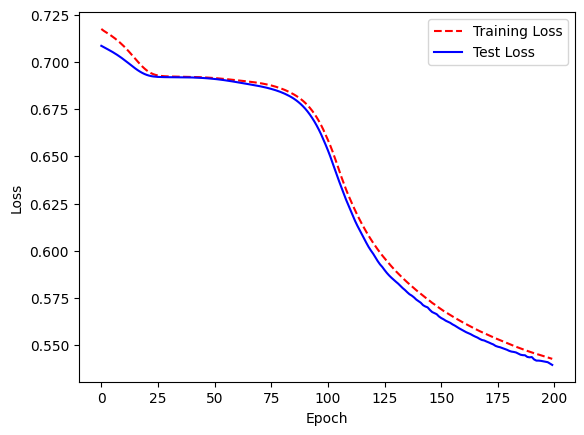

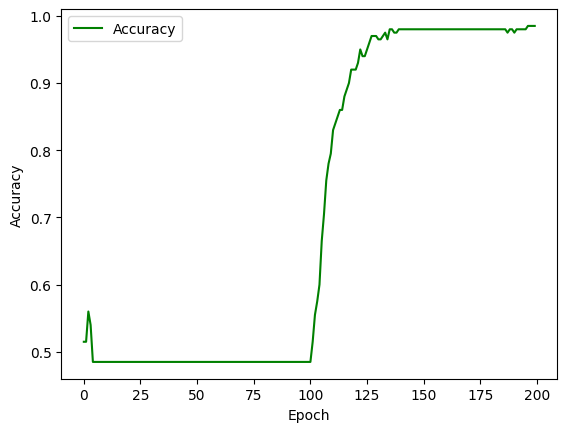

In [185]:
# print the shape and device of X_train, y_train, X_test, y_test
# change np array to tensor
if isinstance(X_train, np.ndarray):
    X_train = torch.from_numpy(X_train).type(torch.float32)
if isinstance(y_train, np.ndarray):
    y_train = torch.from_numpy(y_train).type(torch.float32)
if isinstance(X_test, np.ndarray):
    X_test = torch.from_numpy(X_test).type(torch.float32)
if isinstance(y_test, np.ndarray):
    y_test = torch.from_numpy(y_test).type(torch.float32)


X_test, y_test, X_train, y_train = change_device(device, X_test, y_test, X_train, y_train)
print(f"Shape of X_train: {X_train.shape}")
y_train = y_train.reshape(-1,1)
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
y_test = y_test.reshape(-1,1)
print(f"Shape of y_test: {y_test.shape}")

print(f"Device of X_train: {X_train.device}")
print(f"Device of y_train: {y_train.device}")
print(f"Device of X_test: {X_test.device}")
print(f"Device of y_test: {y_test.device}")

result = train_model(model, loss_fn, optimizer_fn, X_train, y_train, X_test, y_test, epochs=200)


Shape: (200,) | Device: CPU
Shape: (200,) | Device: CPU
Shape: (200,) | Device: CPU
Shape: (200,) | Device: CPU
    Data X0   Data X1  Actual  Predicted
0 -0.718656 -0.329943     1.0   0.762371
1  0.144829  0.731040     1.0   0.762371
2 -0.486845  0.621506     1.0   0.762371
3  0.512952 -0.800250     0.0   0.002937
4 -0.590342 -0.796158     0.0   0.000036
Length of predictions: 200
Shape of predictions: (200,)


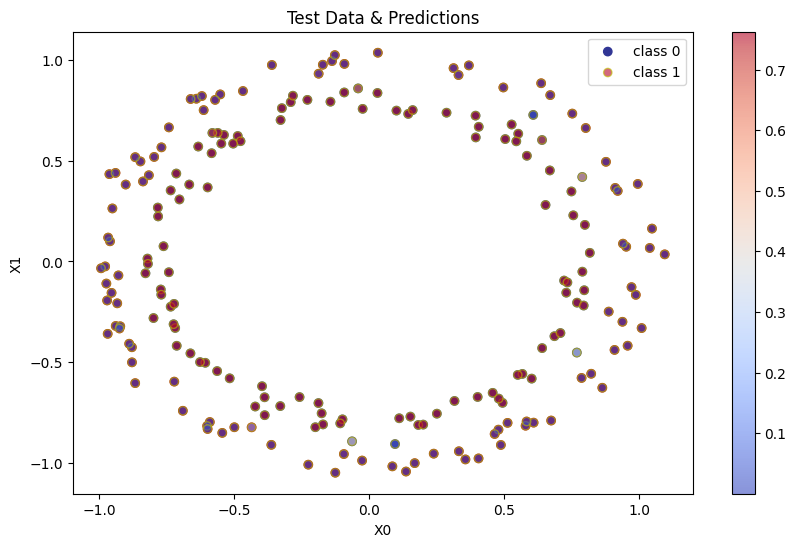

In [186]:
# Make predictions using the trained model
with torch.inference_mode():
    trained_preds = result['model'](X_test)

# Show the predictions
show_preds(X_test, y_test, trained_preds)

Moved Tensor to cpu
Moved Tensor to cpu
Moved Tensor to cpu
Shape: torch.Size([200, 2]) | Device: cpu
Shape: torch.Size([200, 1]) | Device: cpu
Shape: torch.Size([200, 1]) | Device: cpu


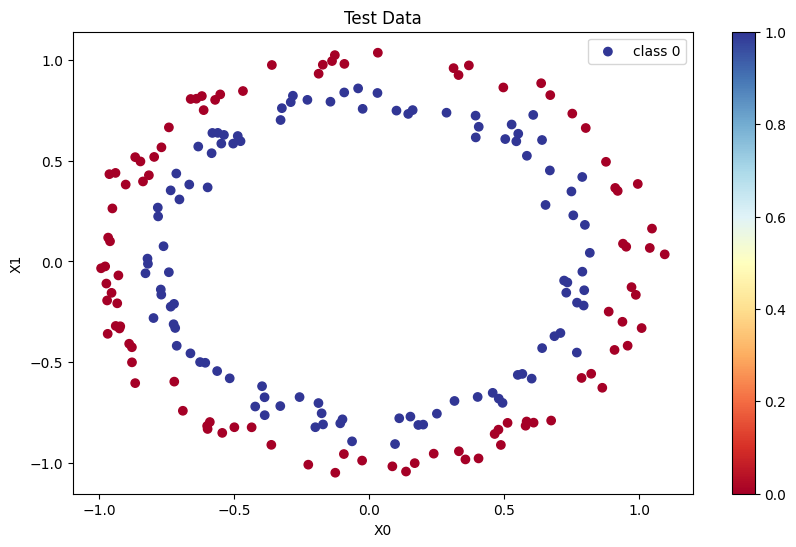

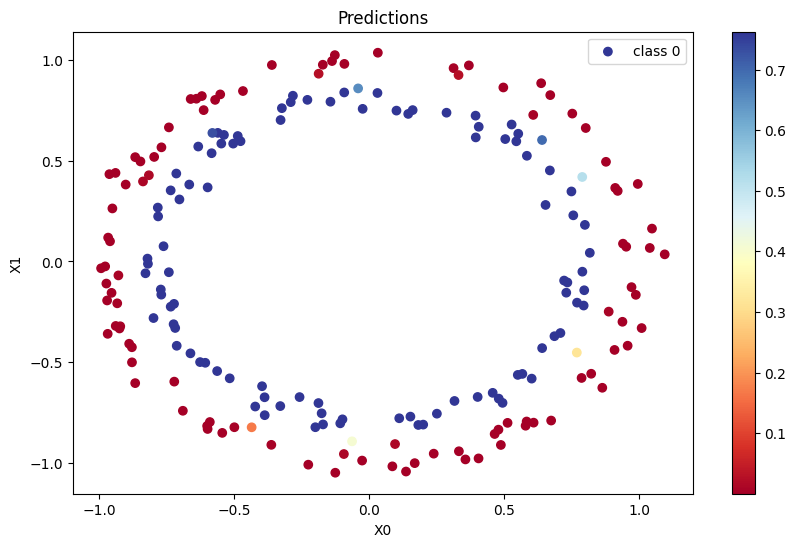

In [187]:
X_test, y_test, trained_preds = change_device('cpu', X_test, y_test, trained_preds)
print_shape_device(X_test, y_test, trained_preds)
plot_scatter(X_test, y_test, title='Test Data')
plot_scatter(X_test, trained_preds, title='Predictions')

In [188]:
preds = normalize_predictions(trained_preds)
print(f"First 5 predictions:\n{preds[:5]}")

First 5 predictions:
tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.]], device='cuda:0')


In [189]:
acc= accuracy_fn(preds, y_test)
print(f"Accuracy of trained model: {acc:.4f}")

Moved Tensor to cuda
Moved Tensor to cuda
Shape: torch.Size([200, 1]) | Device: cuda:0
Shape: torch.Size([200, 1]) | Device: cuda:0
Accuracy of trained model: 0.9850


In [190]:
def change_to_numpy(*args):
    """
    This function converts the given tensors to numpy arrays.

    Parameters:
    *args (torch tensor): Variable length argument list of tensors.

    Returns:
    result (tuple): A tuple containing the tensors converted to numpy arrays.
    """
    result = []
    for arg in args:
        if torch.is_tensor(arg):
            arg = arg.cpu().numpy()
        elif isinstance(arg, np.ndarray):
            pass  # arg is already a numpy array, no need to convert
        else:
            print("Input type not supported. Please provide a torch tensor or a numpy array.")
            continue
        result.append(arg)
    return tuple(result)

In [191]:

X_test, y_test, preds = change_to_numpy(X_test, y_test, preds)

X0=X_test[:,0].squeeze()
X1=X_test[:,1].squeeze()
y_test=y_test.squeeze()
preds=preds.squeeze()

df = pd.DataFrame({'Data X0': X0, 'Data X1': X1, 'Actual': y_test, 'Predicted': preds})
df.head()


,Data X0,Data X1,Actual,Predicted
0,-0.718656,-0.329943,1.0,1.0
1,0.144829,0.731040,1.0,1.0
2,-0.486845,0.621506,1.0,1.0
3,0.512952,-0.800250,0.0,0.0
4,-0.590342,-0.796158,0.0,0.0


In [192]:
# make a function to plot the decision boundary
def plot_decision_boundary_mine(X, y, model, title='Decision Boundary'):
    # Create a meshgrid for our plot
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Convert to torch tensor and move to the correct device
    if isinstance(xx, np.ndarray):
        xx = torch.from_numpy(xx).to(device)
        xx = xx.type(torch.float32)
    if isinstance(yy, np.ndarray):
        yy = torch.from_numpy(yy).to(device)
        yy = yy.type(torch.float32)

    # Use the model to make predictions
    print_shape_device(xx, yy)
    with torch.inference_mode():
        print_shape_device(xx, yy)
        Z = model(torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

    Z = Z.reshape(xx.shape)

    # Move Z back to CPU and convert to numpy for plotting
    Z = Z.cpu().numpy()

    # Plot the contour and training examples
    plt.contourf(xx.cpu().numpy(), yy.cpu().numpy(), Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40)
    plt.title(title)
    plt.show()

Shape: torch.Size([205, 205]) | Device: cuda:0
Shape: torch.Size([205, 205]) | Device: cuda:0
Shape: torch.Size([205, 205]) | Device: cuda:0
Shape: torch.Size([205, 205]) | Device: cuda:0


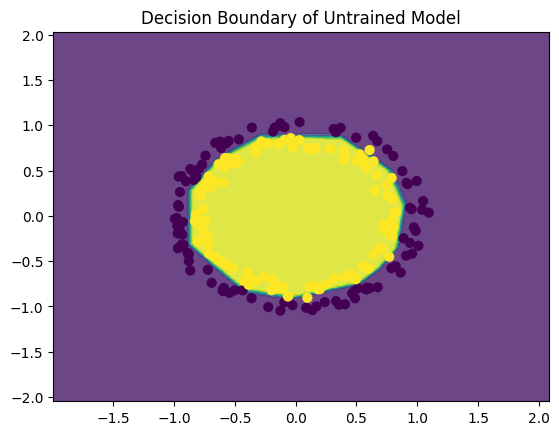

In [193]:
model = model.to('cuda')
plot_decision_boundary_mine(X_test, y_test, model, title='Decision Boundary of Untrained Model')

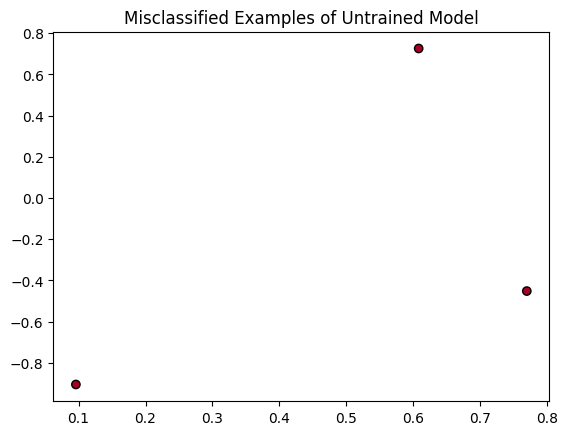

In [194]:
# plot the data sets for which predicitions and actual values are different

def plot_misclassified(X, y, preds, title='Misclassified Examples'):
    # Convert to numpy arrays
    X, y, preds = change_to_numpy(X, y, preds)

    # Get the indices of the misclassified examples
    misclassified_idxs = np.where(y != preds)[0]

    # Plot the misclassified examples
    plt.scatter(X[misclassified_idxs, 0], X[misclassified_idxs, 1], c=y[misclassified_idxs], cmap=plt.cm.RdYlBu, edgecolors='k')
    plt.title(title)
    plt.show()

plot_misclassified(X_test, y_test, preds, title='Misclassified Examples of Untrained Model')